Next weekend, is the Fantasy Football draft for one of my main home leagues.  In Fantasy Football is largely a game of luck.  However, you can gain an advantage on the other players in your league by being more prepared.  This league is full PPR, and each fantasy player can have up to 4 WRs in thier starting lineup each week.  In a full PPR league, fantasy players receive a full point everytime an NFL player in the lineup catchs a pass.  Also, upt to 4 WR is more that the standard of up to 3 WRs in PPR leagues.  So, WR are highly valued assets in this league. In the past, I have been very competive in this league because the rest of the league under-valued the WR position.  However, it seems like this year WR are getting draft much earlier than in recent years. So, I want to see if it my be the right year to change my strategy and draft other positionns earlier than I normally would. The goal of this project is to come up with a good model for predicting average PPG with a few limited statistics to help guide my strategy this year.  The goal is not necessarily to identify under-valued player.

Import potentially needed libraries

In [379]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [380]:
fldr = r"/Users/dennisyoung/Documents/FantasyFootballPPR - Polynomial"

ADP is "Average Draft Position".  This is where each player is typically selected in fantasy football drafts.  This ADP data is from Fantasy Pros, who posts downloadable cvs files, after signing up for a free subscription. The link to this data is: https://www.fantasypros.com/nfl/adp/ppr-overall.php.  All ADP files going back to 2017 were downloaded for use.

In [381]:
adp_yr_list = ["2017","2018","2019","2020","2021","2022","2023","2024"]

adp = pd.DataFrame()

for yr in adp_yr_list:
    file = fldr + "/" + yr + "/" + "FantasyPros_" + yr + "_" + "Overall_ADP_Rankings.csv"
    adp_yr = pd.read_csv(file)
    adp_yr['year'] = pd.to_numeric(yr)
    adp = pd.concat([adp,adp_yr])

adp.head()

,Rank,Player,Team,Bye,POS,ESPN,Sleeper,NFL,RTSports,FFC,AVG,Unnamed: 11,Unnamed: 12,year
0,1.0,David Johnson,NaN,NaN,RB1,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2017
1,2.0,Le'Veon Bell,NaN,NaN,RB2,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2017
2,3.0,Antonio Brown,NaN,NaN,WR1,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2017
3,4.0,Julio Jones,NaN,NaN,WR2,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2017
4,5.0,Odell Beckham Jr.,MIA,1,WR3,5.0,NaN,NaN,NaN,NaN,5.2,NaN,NaN,2017


The example above shows what the csv files typically look like, with 'year' added as an additional field.  There will be some cleaning of this data.  The 'POS' column includes both the players position and positional ranking.  For example, Le'Veon Bell has the 'POS' of "RB2" in 2017.  That means that he is a running back and was typically the 2nd running back drafted in Fantasy Drafts in 2017.  For purposes of this analysis and any machine learning algorithms, the 'POS' column will be separated out into 'Pos' and 'rank'.  So, for Le'Veon Bell in 2017 his 'Pos' will be "RB" and his 'rank' will be 2.  

Note, the fifth row above shows Odell Beckham Jr.'s team in 2017 as "MIA".  However, in 2017, Odell Beckham Jr played for the NY Giants (NYG).  Fantasy Pros uses the players current team in the 'Team' column in thier ADP and PPG files that are used in this project.  So, adding in team specific data to add features to our models would require a separate data source to get the players team for the season they played for in the corresponding year.

In [382]:
## Removing defenses and kickers.  
##This league does not include kickers and defenses are usually the last pick in the draft for me.    
adp = adp[(adp['Player'].notna()) & ((adp['POS'].str.contains("RB"))
        | (adp['POS'].str.contains("WR")) |  (adp['POS'].str.contains("TE"))
        | (adp['POS'].str.contains("QB")))]

## The 'POS'includes the position and the order that the position is drafted on averge.
## For example a 'POS' of "RB26" is a running back is typically the 26th running back drafted
## Two new fields are created 'Pos' and 'rank'.  For the example above 'Pos' is "RB" and 'rank' is 26
adp['rank'] = pd.to_numeric(adp['POS'].str[2:])
adp['Pos'] = adp['POS'].str[:2]

## Using the 'AVG' column for 'ADP'
adp = adp.rename(columns={'AVG':'ADP'})

adp = adp[['Player','Team','ADP','year','rank','Pos']]

adp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2743 entries, 0 to 421
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  2743 non-null   object 
 1   Team    1658 non-null   object 
 2   ADP     2743 non-null   float64
 3   year    2743 non-null   int64  
 4   rank    2743 non-null   int64  
 5   Pos     2743 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 150.0+ KB


There are 2,743 records in the ADP file.  The 'Team' feature has several missing values.  However, since it is only the players current team and not the team at the time of the fantasy draft, it will likely not be used in this project.

"PPG" is an abreviation of Points Per Game.  Each CSV file, contains the points scored each week along with the average for the time period.  Prior to download, the final week of the regular season was removed.  Top players on teams that have already made the NFL playoffs are usually sat during this week.  So, the Fantasy Football championship is usually played on the week prior to the end of the season.  The link to these csv files for download is https://www.fantasypros.com/nfl/reports/leaders/ppr.php?year=2023.

In [383]:
ppg_yr_list = ["2016","2017","2018","2019","2020","2021","2022","2023"]

ppg = pd.DataFrame()

for yr in ppg_yr_list:
    file = fldr + "/" + yr + "/" + "FantasyPros_Fantasy_Football_Points_PPR.csv"
    ppg_yr = pd.read_csv(file)
    # This will be the prior 
    ppg_yr['year'] = pd.to_numeric(yr) + 1
    ppg = pd.concat([ppg,ppg_yr])

ppg

ppg = ppg[(ppg['Player'].notna()) & ((ppg['Pos'].str.contains("RB"))
        | (ppg['Pos'].str.contains("WR")) |  (ppg['Pos'].str.contains("TE"))
        | (ppg['Pos'].str.contains("QB")))]

ppg.head()

,#,Player,Pos,Team,1,2,3,4,5,6,...,12,13,14,15,16,17,AVG,TTL,year,18
0,1.0,David Johnson,RB,FA,23.2,17.3,26.1,14.4,33.5,34.8,...,30.1,38.5,17.1,26.8,33.6,NaN,26.7,400.4,2017,NaN
1,2.0,Aaron Rodgers,QB,NYJ,23.6,17.4,26.4,-,15.9,12.5,...,23.1,16,21.2,12,37.2,NaN,23.1,345.8,2017,NaN
2,3.0,Ezekiel Elliott,RB,DAL,12.2,14.7,18,22.7,32.1,19.4,...,26,20.5,10.7,27.8,22.2,NaN,21.7,325.4,2017,NaN
3,4.0,Matt Ryan,QB,FA,24.4,27.8,19.9,35.5,15,21.6,...,18.3,16.2,21.5,19.3,20,NaN,21.2,318.0,2017,NaN
4,5.0,Le'Veon Bell,RB,FA,-,-,-,22.8,24.4,18.8,...,24.2,22.2,51.8,18.1,28.7,NaN,26.5,317.4,2017,NaN


Above is an example of what the csv input looks like, with minimal cleaning.  The primary addition was the addition of the 'year' field.  The 'year' field here is the year of the data pull plus one.  This PPG may be a feature in our model. So, I want to make sure that I am using historical data when training the model.

As mentioned before, the last week of the regular season was removed from each file to correspond to the fantasy football season.  Let's check the data to make sure it looks similar to expected.

In [384]:
ppg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4193 entries, 0 to 706
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   #       4193 non-null   float64
 1   Player  4193 non-null   object 
 2   Pos     4193 non-null   object 
 3   Team    4193 non-null   object 
 4   1       4193 non-null   object 
 5   2       4193 non-null   object 
 6   3       4193 non-null   object 
 7   4       4193 non-null   object 
 8   5       4193 non-null   object 
 9   6       4193 non-null   object 
 10  7       4193 non-null   object 
 11  8       4193 non-null   object 
 12  9       4193 non-null   object 
 13  10      4193 non-null   object 
 14  11      4193 non-null   object 
 15  12      4193 non-null   object 
 16  13      4193 non-null   object 
 17  14      4193 non-null   object 
 18  15      4193 non-null   object 
 19  16      4193 non-null   object 
 20  17      1952 non-null   object 
 21  AVG     4134 non-null   float64
 22  T

There are 4,193 records in the combined file. Of those 4,134 records have 'AVG', which is our primary measure of interest, populated.  As expected week 18 is NA for all records.  Week 17 has 1,952 records that are not NA.  The NFL changed the season to 18 weeks in 2021, and we added 1 to each year.  So, 'year' should be 2022 or higher for all records with week 17 not NA.  Let's check.

In [385]:
ppg[ppg['17'].notna()].groupby('year')['17'].count()

year
2022    672
2023    644
2024    636
Name: 17, dtype: int64

Looks good.

Now, we know that we can us 'AVG' for Points per Game.  However, it is possible that a couple of really good or bad performances can have a major impact on the mean.  So, we also want to calculate the median PPG for another measure of what a "typical" week may look like for each player.  Even if not used in our model, it will be a useful measure in my draft prep.

In [386]:
ppg = ppg.drop(columns=['#','TTL','Team'])

ppg_melt = pd.melt(ppg, ['Player','year','AVG','Pos'])
ppg_melt = ppg_melt[ppg_melt['value'] != "BYE"]

ppg_melt = ppg_melt[(ppg_melt['value'] != "-") & (ppg_melt['value'].notna())]
ppg_melt['value'] = pd.to_numeric(ppg_melt['value'])
ppg_melt = ppg_melt.groupby(['Player','year','AVG','Pos'], as_index = False)['value'].median()
ppg = ppg_melt.rename(columns={'AVG':'PPG','value':'Med_PPG'})
ppg = ppg[['Player','Pos','PPG','Med_PPG','year']]

ppg.head()

,Player,Pos,PPG,Med_PPG,year
0,A.J. Brown,WR,13.0,12.10,2020
1,A.J. Brown,WR,16.6,16.20,2021
2,A.J. Brown,WR,13.7,9.50,2022
3,A.J. Brown,WR,17.9,16.65,2023
4,A.J. Brown,WR,18.1,17.55,2024


The code below is identical to the previous code for average PPG and median PPG.  The main difference is that the average PPG and median PPG used here will be response variables in our models.  So, the 'year' is year that corresponds to the ADP year.  It does not have "1" added to it.  Also, 'AVG' is now 'Act_PPG' and the median is 'Act_Med_PPG' because these are no longer predictors. 

In [387]:
ppg_yr_list = ["2017","2018","2019","2020","2021","2022","2023"]

curr_ppg = pd.DataFrame()

for yr in ppg_yr_list:
    file = fldr + "/" + yr + "/" + "FantasyPros_Fantasy_Football_Points_PPR.csv"
    curr_ppg_yr = pd.read_csv(file)
    curr_ppg_yr['year'] = pd.to_numeric(yr)
    curr_ppg = pd.concat([curr_ppg,curr_ppg_yr])


curr_ppg = curr_ppg[(curr_ppg['Player'].notna()) & ((curr_ppg['Pos'].str.contains("RB"))
        | (curr_ppg['Pos'].str.contains("WR")) |  (curr_ppg['Pos'].str.contains("TE"))
        | (curr_ppg['Pos'].str.contains("QB")))]

curr_ppg = curr_ppg.drop(columns=['#','TTL','Team'])

curr_ppg_melt = pd.melt(curr_ppg, ['Player','year','AVG','Pos'])
curr_ppg_melt = curr_ppg_melt[curr_ppg_melt['value'] != "BYE"]

curr_ppg_melt = curr_ppg_melt[(curr_ppg_melt['value'] != "-") & (curr_ppg_melt['value'].notna())]
curr_ppg_melt['value'] = pd.to_numeric(curr_ppg_melt['value'])
curr_ppg_melt = curr_ppg_melt.groupby(['Player','year','AVG','Pos'], as_index = False)['value'].median()
curr_ppg = curr_ppg_melt.rename(columns={'AVG':'Act_PPG','value':'Act_Med_PPG'})
curr_ppg = curr_ppg[['Player','Pos','Act_PPG','Act_Med_PPG','year']]

In [388]:
curr_ppg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3890 entries, 0 to 3889
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       3890 non-null   object 
 1   Pos          3890 non-null   object 
 2   Act_PPG      3890 non-null   float64
 3   Act_Med_PPG  3890 non-null   float64
 4   year         3890 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 152.1+ KB


There are response variables available for 3,890 records.

Now, that the ADP and PPG data ready to go.  The predictors 'PPG' and 'Med_PPG' will be merged to the 'ADP' data.  The 

In [389]:
## Merge on the 'PPG' and 'Med_PPG' predictors
df = adp.merge(ppg, how = "left", on = ['Player','year','Pos'])
## Merge on the 'Act_PPG' and 'Act_Med_PPG' response variables
df = df.merge(curr_ppg, how = "left", on = ['Player','year','Pos'])

In [390]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2743 entries, 0 to 2742
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       2743 non-null   object 
 1   Team         1658 non-null   object 
 2   ADP          2743 non-null   float64
 3   year         2743 non-null   int64  
 4   rank         2743 non-null   int64  
 5   Pos          2743 non-null   object 
 6   PPG          1872 non-null   float64
 7   Med_PPG      1872 non-null   float64
 8   Act_PPG      1830 non-null   float64
 9   Act_Med_PPG  1830 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 235.7+ KB


There are 1,872 records with non-null 'PPG' and 1,830 records with non-null 'Act_PPG'.  We know that first year players, "rookies", will have a missing 'PPG', since that is the prior year's points per game.  However, we shouldn't have missing values for 'Act_PPG' unless the players points per game were zero or the year is 2024 becaue the 2024 season has not started yet. Let's look at the data an see if we can remove the missing values. 

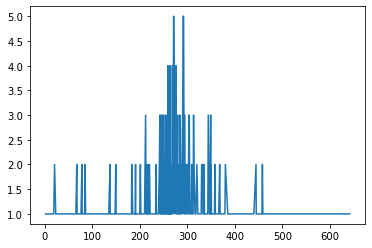

In [391]:
missing = df[(df['Act_PPG'].isna()) & (df['year'] != 2024)].groupby('ADP')['ADP'].count()
plt.plot(missing)

The missing values seem to be concentrated later in the draft.  In this league, there are 12 fantasy teams and each team drafts 15 players.  Since 12 x 15 = 180, it is very unlikely that players with an ADP higher than 250 will be drafted. Also, there are only 32 NFL teams.  So, it is any "QB" or "TE" ranked higher than 32 is extremely unlikely to be drafted in fantasy football.  "QB" and "TE" are typically considered less valuable in typical fantasy football home leagues because you can only start one "QB" and "TE" is usually a very low scoring position.  Let's see how the missing values seem to be consentrated around the different positional rankings.

<AxesSubplot:xlabel='rank', ylabel='Count'>

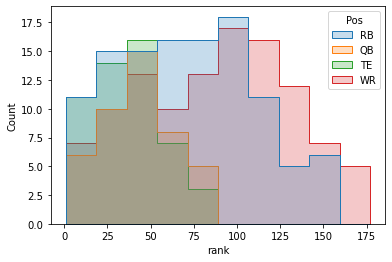

In [392]:
missing_by_rank_pos = df[(df['Act_PPG'].isna()) & (df['year'] != 2024)].groupby(['rank','Pos'],as_index=False)['Player'].count()

sns.histplot(data=missing_by_rank_pos, x="rank", hue="Pos", element="step")

Most of the high ranking missing values seem to be "RB"s and "WR".  However, let's remove some records based on positional ranking first and see how the data looks.  Also, let's separate out "year" equal to 2024 since those records will not be used in the modelling portion of the project.

In [393]:
## Remove QB and TE that are very unlikely to be drafted
df['remove'] = np.where(((df['Pos'] == "QB")|(df['Pos'] == "TE")) & (df['rank'] > 32),1,0)
df_2024 = df[df['year'] == 2024]
df = df[(df['year'] != 2024) & (df['remove'] != 1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2320
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       2066 non-null   object 
 1   Team         1136 non-null   object 
 2   ADP          2066 non-null   float64
 3   year         2066 non-null   int64  
 4   rank         2066 non-null   int64  
 5   Pos          2066 non-null   object 
 6   PPG          1392 non-null   float64
 7   Med_PPG      1392 non-null   float64
 8   Act_PPG      1669 non-null   float64
 9   Act_Med_PPG  1669 non-null   float64
 10  remove       2066 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 193.7+ KB


There still quite a few missing values for 'Act_PPG'.  I am going to remove players with an 'ADP' greater than 250 since those players are very unlikely to be drafted.

In [394]:
df = df[df['ADP'] <= 250]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1550 entries, 0 to 2237
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       1550 non-null   object 
 1   Team         926 non-null    object 
 2   ADP          1550 non-null   float64
 3   year         1550 non-null   int64  
 4   rank         1550 non-null   int64  
 5   Pos          1550 non-null   object 
 6   PPG          1130 non-null   float64
 7   Med_PPG      1130 non-null   float64
 8   Act_PPG      1325 non-null   float64
 9   Act_Med_PPG  1325 non-null   float64
 10  remove       1550 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 145.3+ KB


<AxesSubplot:xlabel='rank', ylabel='Count'>

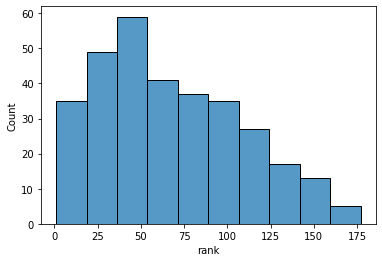

In [303]:
missing = df.groupby(['rank'],as_index=False)['rank'].count()

sns.histplot(data=missing_by_rank_pos, x="rank")

After removing players that were unlikely to be drafted.  Let's see how the missing values are distributed accross years.

In [304]:
df[df['Act_PPG'].isna()].groupby(['year'])['year'].count()

year
2017    84
2018    62
2019    29
2020    16
2021    20
2022    10
2023     4
Name: year, dtype: int64

It looks like most of the missing values are concentrated is later years.  I think it is okay to remove them for this project.  There should still be enough data left for our analysis. I also want to remove any records with 'Act_PPG' = 0, since those are outliers, usually resulting from injury. There is chance that I will do some polynomial regression with either 'ADP' or 'rank'.  I will normalize those measures just in case.

In [305]:
df = df[df['Act_PPG'].notna()]
df = df[df['Act_PPG'] > 0]
## Noramlize 'ADP' and 'rank'
df['ADP_norm'] = df['ADP']/df['ADP'].mean()
df['rank_norm'] = df['rank']/df['rank'].mean()

## Label all cases where the prior year's PPG was missing as 'rookie'
df['rookie'] = np.where(df['PPG'].isna(),1,0)

## Remove unnessary columns
df = df.drop(columns=['remove','Team'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 0 to 2236
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       1319 non-null   object 
 1   ADP          1319 non-null   float64
 2   year         1319 non-null   int64  
 3   rank         1319 non-null   int64  
 4   Pos          1319 non-null   object 
 5   PPG          1117 non-null   float64
 6   Med_PPG      1117 non-null   float64
 7   Act_PPG      1319 non-null   float64
 8   Act_Med_PPG  1319 non-null   float64
 9   ADP_norm     1319 non-null   float64
 10  rank_norm    1319 non-null   float64
 11  rookie       1319 non-null   int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 134.0+ KB


Okay, there is now 1,319 records with no missing values on the fields of interest.  To make sure, the cases are distributed well accross 'rank' and 'ADP', the training and test split will be done by year rather than percentage of records.  The test dataset will be the most recent years of 2022 and 2023.  The training dataset will be 2017 through 2021.

In [306]:
train = df[df['year'].isin([2017,2018,2019,2021])]
test = df[df['year'].isin([2022,2023])]

Based on the charts below, it looks like there is decent linear relationship between 'ADP' and the actual 'PPG' for each position group.

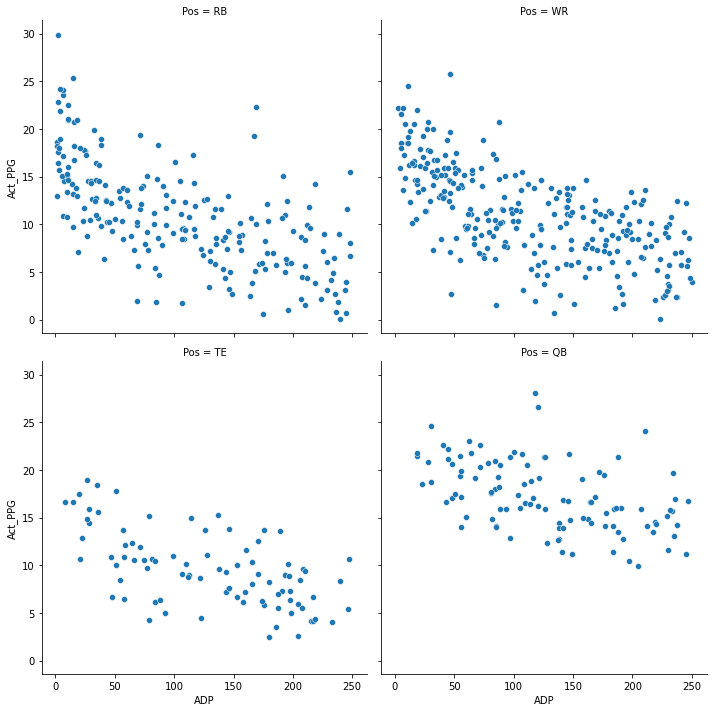

In [307]:
sns.relplot(data=train, x="ADP", y="Act_PPG", col="Pos", col_wrap = 2)

The two premium positions in fantasy football are "RB" and "WR".  Typically, the "RB"s have gone earlier than the "WR"s by ADP, but that seems to be changing in recent years, in particular this year.  It may be better to look at 'Act_PPG' vs positional 'rank'.  Based on the scatterplots below, there appears to be a linear relationship between 'rank' and 'Act_PPG'.  It is unclear if there is a stronger relationship between 'rank' or 'ADP to 'Act_PPG'

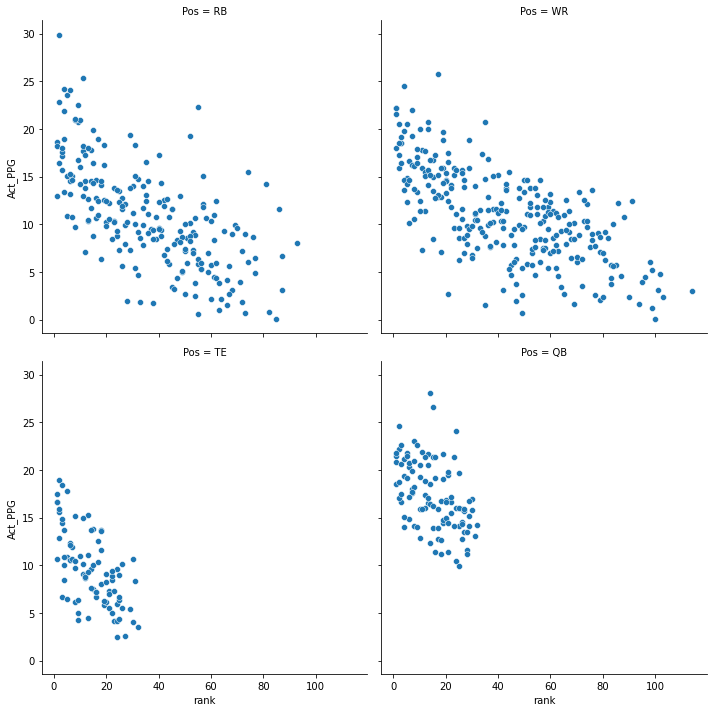

In [308]:
sns.relplot(data=train, x="rank", y="Act_PPG", col="Pos", col_wrap = 2)

Looking at the scatterplots below.  There is a very strong correlation between 'ADP' and 'rank'.

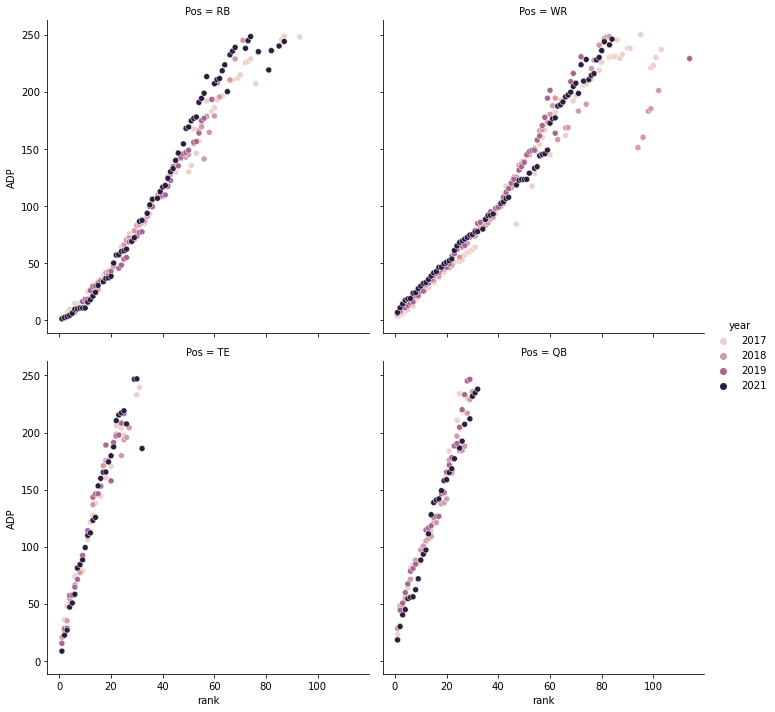

In [309]:
sns.relplot(data=train, x="rank", y="ADP",hue="year", col="Pos", col_wrap = 2)

Looking at the heatmap below, 'rank' appears to slightly more correlated with 'Act_PPG' than 'ADP'.  'Act_PPG' and 'Act_Med_PPG' are very highly correlated.  So, I think it is safe to use 'Act_PPG' as the response in all of our models.

<AxesSubplot:>

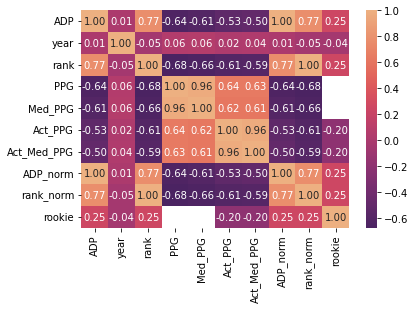

In [310]:
sns.heatmap(train.corr(), annot = True , fmt=".2f", cmap = "flare_r")

Rather than treating 'Pos' as a categorical variable. I think it is best model each position group individually.  The data for "QB" and "TE" might be a little sparce.  So, "RB" and "WR" will be the focus.  "RB" and "WR" are the msot important position groups in fantasy football.

In [311]:
# Split Training data by position group

train_wr = train[train['Pos'] == "WR"]
train_rb = train[train['Pos'] == "RB"]
train_qb = train[train['Pos'] == "QB"]
train_te = train[train['Pos'] == "TE"]

# Split Testing by position group

test_wr = test[test['Pos'] == "WR"]
test_rb = test[test['Pos'] == "RB"]
test_qb = test[test['Pos'] == "QB"]
test_te = test[test['Pos'] == "TE"]

Let's run simiple linear models with 'ADP' and 'rank' as our features to see how well they fit the 'Act_PPG' for WRs.

In [312]:
model_wr_simple_adp = smf.ols(formula='Act_PPG ~ ADP', 
                data=train_wr).fit()

model_wr_simple_rank = smf.ols(formula='Act_PPG ~ rank', 
                data=train_wr).fit()

In [239]:
model_wr_simple_adp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Act_PPG   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     200.5
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           1.93e-34
Time:                        14:54:15   Log-Likelihood:                -744.61
No. Observations:                 273   AIC:                             1493.
Df Residuals:                     271   BIC:                             1500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.9786      0.415     38.548      0.000      15.163      16.795
ADP           -0.0435      0.003    -14.158      0.000      -0.050      -0.037
==============================================================================
Omnibus:                        2.077   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.354   Jarque-Bera (JB):                1.873
Skew:                          -0.200   Prob(JB):                        0.392
Kurtosis:                       3.070   Cond. No.                         249.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The simple linear model with 'rank' as the feature seems to perform better than the simple linear model with 'ADP' as the feature.  The model with 'rank' as the feature has an R-squared of 0.485, which is better than the R-squared of 0.422 in the model with 'rank' as the feature.  So, going forward the project will focus on positional rank rather than 'ADP' for WRs.

In [240]:
model_wr_simple_rank.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Act_PPG   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     242.4
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           1.78e-39
Time:                        14:54:17   Log-Likelihood:                -732.98
No. Observations:                 273   AIC:                             1470.
Df Residuals:                     271   BIC:                             1477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4307      0.407     40.334      0.000      15.629      17.233
rank          -0.1258      0.008    -15.569      0.000      -0.142      -0.110
==============================================================================
Omnibus:                        2.917   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.586
Skew:                          -0.197   Prob(JB):                        0.274
Kurtosis:                       3.270   Cond. No.                         95.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression plot seems to fit the data pretty well. However, it does seem to underestimate the 'Act_PPG' for highly ranking players.  A polynomial model may provide a better fit.

<AxesSubplot:xlabel='rank', ylabel='Act_PPG'>

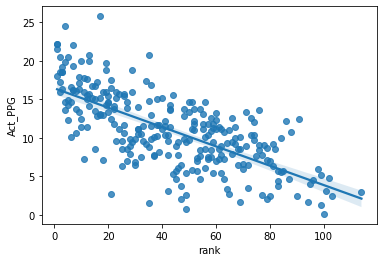

In [241]:
sns.regplot(data=train_wr, x="rank", y="Act_PPG")

Let's loop through different polynomials and see which ones give us the highest adjusted R-squared.

In [242]:
f = 'Act_PPG ~ '

rsq = []

lst = ['np.power(rank_norm,1)',' + np.power(rank_norm,2)','+ np.power(rank_norm,3)','+ np.power(rank_norm,4)'
      ,' + np.power(rank_norm,5)','+ np.power(rank_norm,6)','+ np.power(rank_norm,7)'
      ,' + np.power(rank_norm,8)','+ np.power(rank_norm,9)','+ np.power(rank_norm,10)']


for i in lst:
    f += i
    model = smf.ols(formula=f , data=train_wr).fit() 
    val = model.rsquared_adj
    rsq.append(val)
    
rsq

[0.4701765473384316,
 0.4832327520867864,
 0.502907831383828,
 0.5011246182860853,
 0.500929463129977,
 0.5008865167107621,
 0.5004693426173928,
 0.5029204510898693,
 0.5022161090208057,
 0.5012915628727039]

Looking at the results above, a polynomial of degree 3 seems to give a better adjusted R-squared, that is similar to the higher order polynomials.  Below is the regression line for the polynomial of degree 3.

<AxesSubplot:xlabel='rank_norm', ylabel='Act_PPG'>

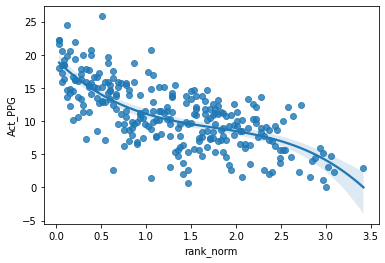

In [243]:
sns.regplot(data=train_wr, x="rank_norm", y="Act_PPG", order = 3)

This model looks pretty good.  Let's fit the model and look at the results.

In [244]:
model_wr_poly = smf.ols('Act_PPG ~ np.power(rank_norm,1) + np.power(rank_norm,2) + np.power(rank_norm,3)'
                     ,data=train_wr).fit()

This fit looks pretty good.  The adjusted R-squared increased from 0.470 to 0.503, as expected.  All features have a p-value < 0.05.

In [245]:
model_wr_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Act_PPG   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     92.73
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           3.13e-41
Time:                        14:56:02   Log-Likelihood:                -723.27
No. Observations:                 273   AIC:                             1455.
Df Residuals:                     269   BIC:                             1469.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19.2198      0.740     25.970      0.000      17.763      20.677
np.power(rank_norm, 1)   -13.3009      2.143     -6.208      0.000     -17.519      -9.082
np.power(rank_norm, 2)     6.3962      1.643      3.894      0.000       3.162       9.630
np.power(rank_norm, 3)    -1.2131      0.355     -3.419      0.001      -1.912      -0.514
==============================================================================
Omnibus:                        1.689   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.430   Jarque-Bera (JB):                1.404
Skew:                          -0.101   Prob(JB):                        0.496
Kurtosis:                       3.288   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear fit for RB also looks pretty good. However, like WR, it seems to be underestimating the 'Act_PPG' for highly ranked players.  A polynomial model might work better.

<AxesSubplot:xlabel='rank', ylabel='Act_PPG'>

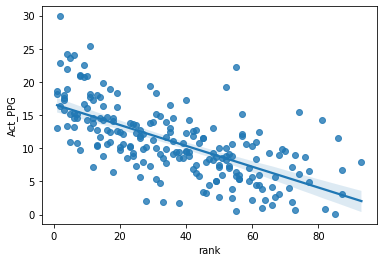

In [211]:
sns.regplot(data=train_rb, x="rank", y="Act_PPG")

Let's run through a loop, similar to the one for WRs.

In [246]:
f = 'Act_PPG ~ '

rsq = []

lst = ['np.power(rank_norm,1)',' + np.power(rank_norm,2)','+ np.power(rank_norm,3)','+ np.power(rank_norm,4)'
      ,' + np.power(rank_norm,5)','+ np.power(rank_norm,6)','+ np.power(rank_norm,7)'
      ,' + np.power(rank_norm,8)','+ np.power(rank_norm,9)','+ np.power(rank_norm,10)']


for i in lst:
    f += i
    model = smf.ols(formula=f , data=train_rb).fit() 
    val = model.rsquared_adj
    rsq.append(val)
    
rsq

[0.4226061021714751,
 0.4636968362312057,
 0.4637464541186609,
 0.46439127299110894,
 0.4619942921271216,
 0.46212625236553595,
 0.46150192985461613,
 0.45965057177549695,
 0.457158722949368,
 0.456908277393835]

Looking at the results above, a polynomial of degree 2 seems to give a better adjusted R-squared, that is similar to the higher order polynomials.  Below is the regression line for the polynomial of degree 2.

<AxesSubplot:xlabel='rank_norm', ylabel='Act_PPG'>

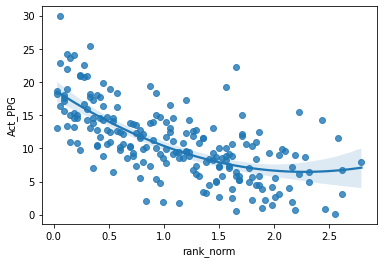

In [247]:
sns.regplot(data=train_rb, x="rank_norm", y="Act_PPG", order = 2)

Fitting both the simple regression model and the polynomial regression model for RBs.  The summary below for the polynomial model shows that each feature has a p-value < 0.05.

In [248]:
## Fitting simple regression for RBs for evaluation purposes
model_rb_simple = smf.ols('Act_PPG ~ rank'
                     ,data=train_rb).fit()

## Fitting polynomial regression model
model_rb_poly = smf.ols('Act_PPG ~ np.power(rank_norm,1) + np.power(rank_norm,2)'
                     ,data=train_rb).fit()
                     
model_rb_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Act_PPG   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     93.08
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           1.05e-29
Time:                        14:57:02   Log-Likelihood:                -599.33
No. Observations:                 214   AIC:                             1205.
Df Residuals:                     211   BIC:                             1215.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 18.8705      0.745     25.330      0.000      17.402      20.339
np.power(rank_norm, 1)   -10.9095      1.424     -7.660      0.000     -13.717      -8.102
np.power(rank_norm, 2)     2.3968      0.577      4.152      0.000       1.259       3.535
==============================================================================
Omnibus:                       11.601   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.314
Skew:                           0.495   Prob(JB):                      0.00212
Kurtosis:                       3.633   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's now loop through different polynomial models for QBs and see which ones give us the highest adjusted R-squared.

In [249]:
f = 'Act_PPG ~ '

rsq = []

lst = ['np.power(rank_norm,1)',' + np.power(rank_norm,2)','+ np.power(rank_norm,3)','+ np.power(rank_norm,4)'
      ,' + np.power(rank_norm,5)','+ np.power(rank_norm,6)','+ np.power(rank_norm,7)'
      ,' + np.power(rank_norm,8)','+ np.power(rank_norm,9)','+ np.power(rank_norm,10)']


for i in lst:
    f += i
    model = smf.ols(formula=f , data=train_qb).fit() 
    val = model.rsquared_adj
    rsq.append(val)
    
rsq

[0.2216954696940926,
 0.21427585377537084,
 0.20649655231708797,
 0.2033528475102624,
 0.19839060060975988,
 0.19221913423064252,
 0.18558145918913416,
 0.18464807906873115,
 0.1929645622199856,
 0.1844270304947494]

For QBs, the adjusted R-Squared decreases as the degrees increase.  So, the simple linear regression model seems like the best fit. However, generally speaking the fit for QBs does not look very good.  Below is the regression plot for 'rank' vs 'Act_PPG'

<AxesSubplot:xlabel='rank', ylabel='Act_PPG'>

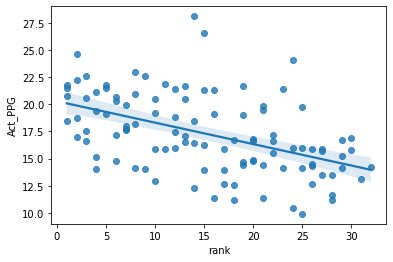

In [216]:
sns.regplot(data=train_qb, x="rank", y="Act_PPG")

It look like the slope of the line has changed year over year. It looks like fantasy analyst are getting better at predicting fantasy performance for QBs each year.  It also looks like the data might be skewed by two exteme outliers, Patrick Mahomes in 2018 and Lamar Jackson in 2019.  Both of these players had very strong fantasy seasons in their second year, after barely playing in their first year.  There are other outliers as well.  However, since those values are so extreme, I am going to try removing those specific cases and seeing if the model performance is improved.

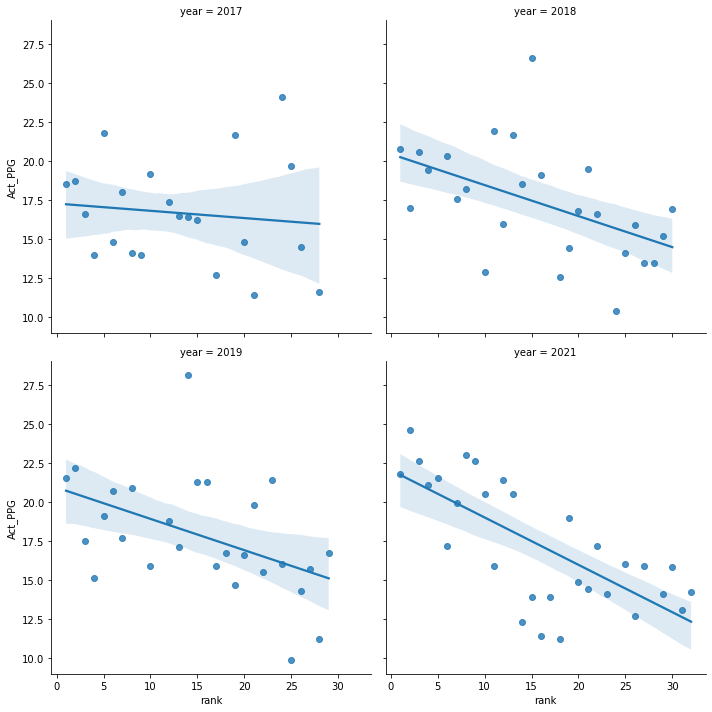

In [217]:
sns.lmplot(data=train_qb, x="rank", y="Act_PPG", col="year",col_wrap=2)

In [251]:
train_qb_no_out = train_qb[~(((train_qb['Player'] == "Patrick Mahomes II") & (train_qb['year'] == 2018))
                             |((train_qb['Player'] == "Lamar Jackson") & (train_qb['year'] == 2019)))]

Running through the loop again to see how the removal of those exteme outliers changed performance.  It looks like the simple regression model is still the better model.  As expected, the adjusted R-squared improved from 0.22 to 0.26 with the removal of the outliers.  Below is the new regression line. It looks very similar to the previous line.

<AxesSubplot:xlabel='rank', ylabel='Act_PPG'>

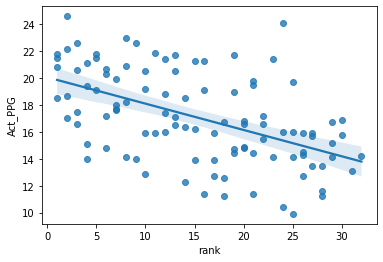

In [252]:
sns.regplot(data=train_qb_no_out, x="rank", y="Act_PPG")

In [253]:
f = 'Act_PPG ~ '

rsq = []

lst = ['np.power(rank_norm,1)',' + np.power(rank_norm,2)','+ np.power(rank_norm,3)','+ np.power(rank_norm,4)'
      ,' + np.power(rank_norm,5)','+ np.power(rank_norm,6)','+ np.power(rank_norm,7)'
      ,' + np.power(rank_norm,8)','+ np.power(rank_norm,9)','+ np.power(rank_norm,10)']


for i in lst:
    f += i
    model = smf.ols(formula=f , data=train_qb_no_out).fit() 
    val = model.rsquared_adj
    rsq.append(val)
    
rsq

[0.2576779844751822,
 0.2525639054964287,
 0.24540171336826466,
 0.23802315952729558,
 0.2307614871703374,
 0.23214009021935333,
 0.22406083606098715,
 0.23385550245776898,
 0.23325177875238856,
 0.22517878894702503]

In [314]:
## Train the model with with outlier included for evaluation purposes
model_qb = smf.ols('Act_PPG ~ rank'
                     ,data=train_qb).fit()


model_qb_simple = smf.ols('Act_PPG ~ rank'
                     ,data=train_qb_no_out).fit()
                     
model_qb_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Act_PPG   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     36.41
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           2.66e-08
Time:                        17:46:25   Log-Likelihood:                -255.71
No. Observations:                 103   AIC:                             515.4
Df Residuals:                     101   BIC:                             520.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.0600      0.570     35.169      0.000      18.929      21.192
rank          -0.1958      0.032     -6.034      0.000      -0.260      -0.131
==============================================================================
Omnibus:                        0.369   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.496
Skew:                           0.127   Prob(JB):                        0.780
Kurtosis:                       2.774   Cond. No.                         34.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Below is the simple regression for TEs.  Let's see if a polynomial model fits better.

<AxesSubplot:xlabel='rank', ylabel='Act_PPG'>

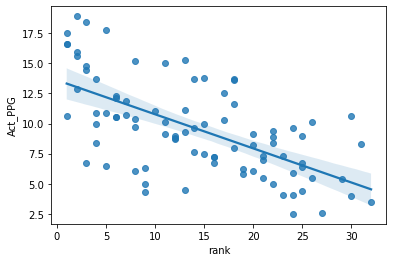

In [255]:
sns.regplot(data=train_te, x="rank", y="Act_PPG")

In [256]:
f = 'Act_PPG ~ '

rsq = []

lst = ['np.power(rank_norm,1)',' + np.power(rank_norm,2)','+ np.power(rank_norm,3)','+ np.power(rank_norm,4)'
      ,' + np.power(rank_norm,5)','+ np.power(rank_norm,6)','+ np.power(rank_norm,7)'
      ,' + np.power(rank_norm,8)','+ np.power(rank_norm,9)','+ np.power(rank_norm,10)']


for i in lst:
    f += i
    model = smf.ols(formula=f , data=train_te).fit() 
    val = model.rsquared_adj
    rsq.append(val)
    
rsq

[0.38755746667117175,
 0.3958279438767697,
 0.40244533801969695,
 0.43301540977125086,
 0.4266070335901705,
 0.44003575350353785,
 0.4333810847151873,
 0.4264554948253174,
 0.4194656548535869,
 0.4253459486449229]

It looks like a polynomial regression with degree of 4 is a good place to start.  So, I will run that polynomial regression model and review the results.

In [257]:
model_te_poly = smf.ols('Act_PPG ~ np.power(rank_norm,1)+ np.power(rank_norm,2) + np.power(rank_norm,3) + np.power(rank_norm,4)'
                     ,data=train_te).fit()
                     
model_te_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Act_PPG   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     17.61
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           1.69e-10
Time:                        14:58:53   Log-Likelihood:                -217.11
No. Observations:                  88   AIC:                             444.2
Df Residuals:                      83   BIC:                             456.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 18.5173      1.686     10.985      0.000      15.164      21.870
np.power(rank_norm, 1)   -82.5916     24.654     -3.350      0.001    -131.627     -33.556
np.power(rank_norm, 2)   282.3874    103.775      2.721      0.008      75.984     488.791
np.power(rank_norm, 3)  -406.8193    162.133     -2.509      0.014    -729.294     -84.344
np.power(rank_norm, 4)   197.0807     83.815      2.351      0.021      30.377     363.785
==============================================================================
Omnibus:                        0.514   Durbin-Watson:                   2.336
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.666
Skew:                           0.120   Prob(JB):                        0.717
Kurtosis:                       2.647   Cond. No.                         773.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The feature with degree of 4 has improved adjusted R-squared and all features have a p-value < 0.05.  This seems likea a pretty good fit.

<AxesSubplot:xlabel='rank_norm', ylabel='Act_PPG'>

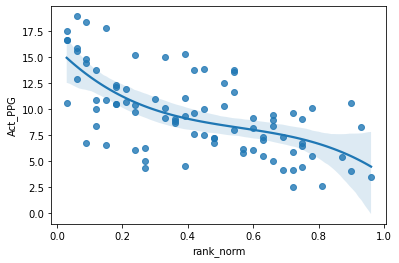

In [258]:
sns.regplot(data=train_te, x="rank_norm", y="Act_PPG", order = 3)

Fit both the simple and polynomial regression models to the test data.  For QBs, there is no polynomial regression model.  The model with outliers excluded will be evaluated against the model with the outliers included.

In [353]:
## Fit the polynomial regression models to the test data
train.loc[train['Pos'] == 'WR', 'Pred_Complex'] = model_wr_poly.predict(train_wr)
train.loc[train['Pos'] == 'RB', 'Pred_Complex'] = model_rb_poly.predict(train_rb)
train.loc[train['Pos'] == 'TE', 'Pred_Complex'] = model_te_poly.predict(train_te)

## Fit the simple regression models to the test data
train.loc[train['Pos'] == 'WR', 'Pred_Simple'] = model_wr_simple_rank.predict(train_wr)
train.loc[train['Pos'] == 'RB', 'Pred_Simple'] = model_rb_simple.predict(train_rb)
train.loc[train['Pos'] == 'TE', 'Pred_Simple'] = model_te_simple.predict(train_te)

### Simple linear regression was the best fit for QBs.  Will evaluate with and without exclusions
train.loc[train['Pos'] == 'QB', 'Pred_Complex'] = model_qb_simple.predict(train_qb) ## simple regresssion with outliers excluded
train.loc[train['Pos'] == 'QB', 'Pred_Simple'] = model_qb.predict(train_qb)## simple regresssion w/o outlier exlusion

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 0 to 1695
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        680 non-null    object 
 1   ADP           680 non-null    float64
 2   year          680 non-null    int64  
 3   rank          680 non-null    int64  
 4   Pos           680 non-null    object 
 5   PPG           571 non-null    float64
 6   Med_PPG       571 non-null    float64
 7   Act_PPG       680 non-null    float64
 8   Act_Med_PPG   680 non-null    float64
 9   ADP_norm      680 non-null    float64
 10  rank_norm     680 non-null    float64
 11  rookie        680 non-null    int64  
 12  Pred_Complex  680 non-null    float64
 13  Pred_Simple   680 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 95.9+ KB


In [336]:
## Fit the polynomial regression models to the test data
pred_poly_wr = model_wr_poly.predict(test_wr)
pred_poly_rb = model_rb_poly.predict(test_rb)
pred_poly_te = model_te_poly.predict(test_te)

## Fit the simple regression models to the test data
pred_simple_wr = model_wr_simple_rank.predict(test_wr)
pred_simple_rb = model_rb_simple.predict(test_rb)
pred_simple_te = model_te_simple.predict(test_te)

### Simple linear regression was the best fit for QBs.  Will evaluate with and without exclusions
pred_exlude_out_qb = model_qb_simple.predict(test_qb) ## simple regresssion with outliers excluded
pred_include_out_qb = model_qb.predict(test_qb) ## simple regresssion w/o outlier exlusion

In [351]:
## Fit the polynomial regression models to the test data
test.loc[test['Pos'] == 'WR', 'Pred_Complex'] = model_wr_poly.predict(test_wr)
test.loc[test['Pos'] == 'RB', 'Pred_Complex'] = model_rb_poly.predict(test_rb)
test.loc[test['Pos'] == 'TE', 'Pred_Complex'] = model_te_poly.predict(test_te)

## Fit the simple regression models to the test data
test.loc[test['Pos'] == 'WR', 'Pred_Simple'] = model_wr_simple_rank.predict(test_wr)
test.loc[test['Pos'] == 'RB', 'Pred_Simple'] = model_rb_simple.predict(test_rb)
test.loc[test['Pos'] == 'TE', 'Pred_Simple'] = model_te_simple.predict(test_te)

### Simple linear regression was the best fit for QBs.  Will evaluate with and without exclusions
test.loc[test['Pos'] == 'QB', 'Pred_Complex'] = model_qb_simple.predict(test_qb) ## simple regresssion with outliers excluded
test.loc[test['Pos'] == 'QB', 'Pred_Simple'] = model_qb.predict(test_qb)## simple regresssion w/o outlier exlusion

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433 entries, 1762 to 2236
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Player        433 non-null    object 
 1   ADP           433 non-null    float64
 2   year          433 non-null    int64  
 3   rank          433 non-null    int64  
 4   Pos           433 non-null    object 
 5   PPG           368 non-null    float64
 6   Med_PPG       368 non-null    float64
 7   Act_PPG       433 non-null    float64
 8   Act_Med_PPG   433 non-null    float64
 9   ADP_norm      433 non-null    float64
 10  rank_norm     433 non-null    float64
 11  rookie        433 non-null    int64  
 12  Pred1         433 non-null    float64
 13  Pred_Complex  433 non-null    float64
 14  Pred_Simple   433 non-null    float64
 15  Pred1_Simple  267 non-null    float64
dtypes: float64(11), int64(3), object(2)
memory usage: 73.7+ KB


The model results have been added to our test data.  Let's see how it looks. The charts below show the results from our combination of polynomial regression models and the QB model with the two outliers exluded.  In general the models looks pretty good. There does appear to be some room for improvement in the RB model. But, overall I am happy with the results.

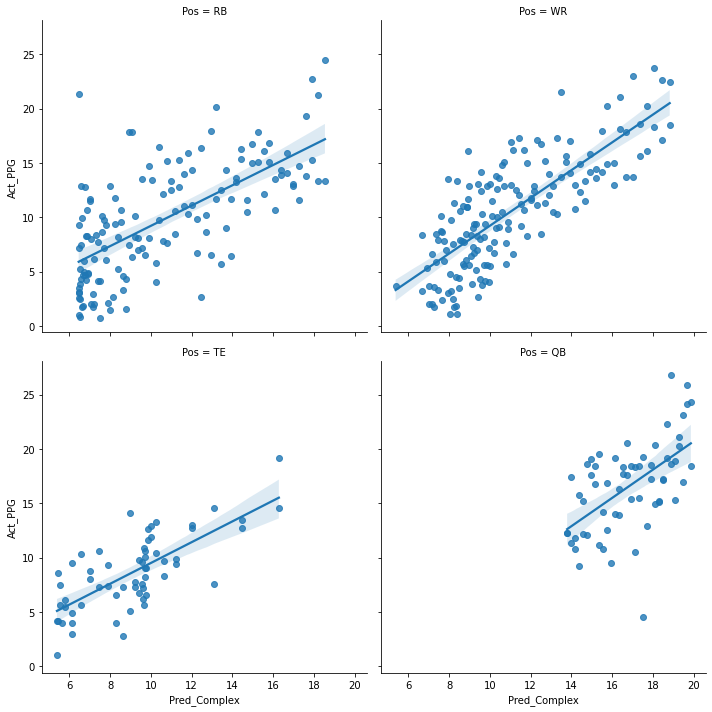

In [338]:
sns.lmplot(data=test, x="Pred_Complex", y="Act_PPG", col="Pos",col_wrap=2)

Below are the predictions from the simple linear regression models compared to 'ACT_PPG'.  The charts look very similar to the charts above.  Only the WR model is noticably tighter around the line for the polynomial model.

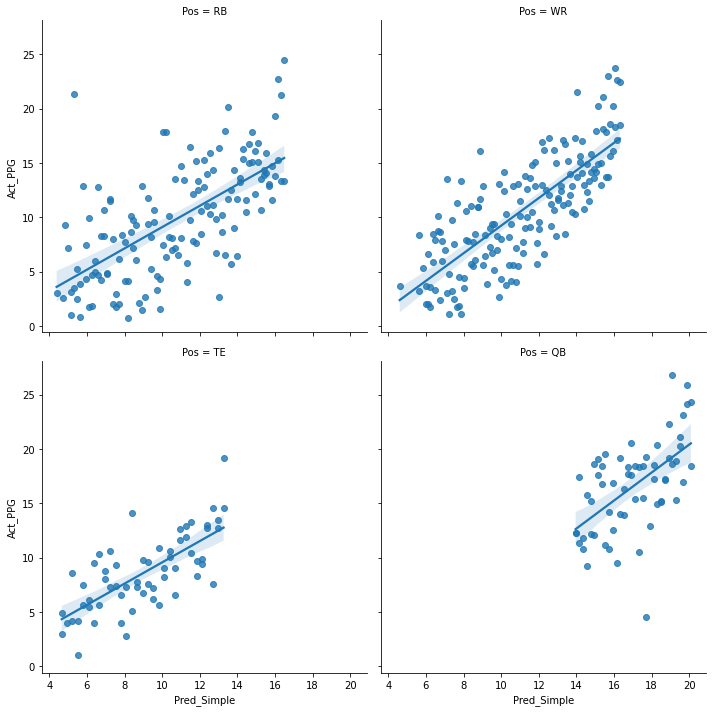

In [340]:
sns.lmplot(data=test, x="Pred_Simple", y="Act_PPG", col="Pos",col_wrap=2)

Let's see how the predictions from the two models compare.  For QBs, the models are nearly identical, which makes sense because they are both simple linear regression models. The polynomial regression models for RB and WR both show higher PPG early in the draft, with fairly steep drops, and flattening towards the end.  The polynomial model shows a some extreme values for very early TE and some flattening around 10 PPG, which matches my experience with the the position.

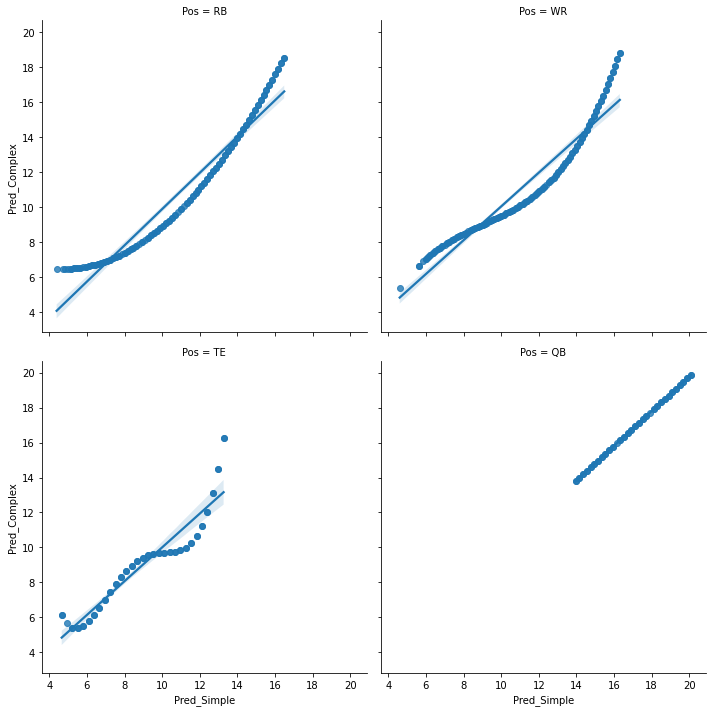

In [343]:
sns.lmplot(data=test, x="Pred_Simple", y="Pred_Complex", col="Pos",col_wrap=2)

In [355]:
R2_test_complex = r2_score(test['Act_PPG'],test['Pred_Complex'])
R2_test_simple = r2_score(test['Act_PPG'],test['Pred_Simple'])
R2_train_complex = r2_score(train['Act_PPG'],train['Pred_Complex'])
R2_train_simple = r2_score(train['Act_PPG'],train['Pred_Simple'])

mae_test_complex = mean_absolute_error(test['Act_PPG'],test['Pred_Complex'])
mae_test_simple = mean_absolute_error(test['Act_PPG'],test['Pred_Simple'])
mae_train_complex = mean_absolute_error(train['Act_PPG'],train['Pred_Complex'])
mae_train_simple = mean_absolute_error(train['Act_PPG'],train['Pred_Simple'])


mape_test_complex = mean_absolute_percentage_error(test['Act_PPG'],test['Pred_Complex'])
mape_test_simple = mean_absolute_percentage_error(test['Act_PPG'],test['Pred_Simple'])
mape_train_complex = mean_absolute_percentage_error(train['Act_PPG'],train['Pred_Complex'])
mape_train_simple = mean_absolute_percentage_error(train['Act_PPG'],train['Pred_Simple'])


mse_test_complex = mean_squared_error(test['Act_PPG'],test['Pred_Complex'])
mse_test_simple = mean_squared_error(test['Act_PPG'],test['Pred_Simple'])
mse_train_complex = mean_squared_error(train['Act_PPG'],train['Pred_Complex'])
mse_train_simple = mean_squared_error(train['Act_PPG'],train['Pred_Simple'])

In [403]:
                
data_np = np.array([["test_complex","test_simple","train_complex","train_simple"], 
         [R2_test_complex,R2_test_simple,R2_train_complex,R2_train_simple],
         [mae_test_complex,mae_test_simple,mae_train_complex,mae_train_simple],
         [mape_test_complex,mape_test_simple,mape_train_complex,mape_train_simple],
         [mse_test_complex,mse_test_simple,mse_train_complex,mse_train_simple]
         ])

results = pd.DataFrame(data = data_np).T

results.columns = ["Data_Model","r_squared","mae","mape","mse"]

results

,Data_Model,r_squared,mae,mape,mse
0,test_complex,0.5839070318285231,2.8023203844271056,0.5085282685147675,11.998141282280102
1,test_simple,0.571185107161043,2.7989295486847303,0.49889061393877865,12.36498105420349
2,train_complex,0.5704069108381018,2.737695441858727,0.564188014306332,12.319450531375931
3,train_simple,0.5398665681687713,2.842507270696806,0.5177705166463991,13.19525661443025


The results show that the polynomial regression model still has a slightly better r-squared and mean squared error than the simple regression model.  The mean absolute error and mean percent absolute error are very similar between the polymomial regression model and the simple regresssion model.  Interestingly, the polynomial regression model performed worse than the simple regression model on MAPE on the training dataset. Nonetheless, I feel confident that the polynomial regression model gives a good estimate of what PPG I should expect at a given positional 'rank'.

## Final Output

Now, I will fit the polynomial models to the 2024 positional rankings.  The final output will be a "cheat sheet" that includes the ADP, prior year PPG, the prior year median PPG, and the predicted PPG.  The predicted PPG won't help me indentify undervalued players because the only input is the positional ranking.  However, it will help me identify how much the player should score to beat their ADP. In addition, when drafting it all comes down to which player you select based a few that you are choosing from.  Tie-breakers matter.  If I am deciding between an RB that I like and a WR that I like, if there are other WRs with similar predicted points available in the next round of the draft, I might select the RB.  When deciding between two players at the same position in a particular round, it is good to know what their PPG and median PPG were in the previous year.  

In [401]:

df_2024['rank_norm'] = df_2024['rank']/df_2024['rank'].mean()


curr_yr = df_2024[(df_2024['ADP'] <= 250) & (df_2024['remove'] == 0)]

wr = curr_yr[curr_yr['Pos'] == 'WR']
rb = curr_yr[curr_yr['Pos'] == 'RB']
qb = curr_yr[curr_yr['Pos'] == 'QB']
te = curr_yr[curr_yr['Pos'] == 'TE']


## Fit the polynomial regression models to the test data
curr_yr.loc[curr_yr['Pos'] == 'WR', 'Pred_Complex'] = model_wr_poly.predict(wr)
curr_yr.loc[curr_yr['Pos'] == 'RB', 'Pred_Complex'] = model_rb_poly.predict(rb)
curr_yr.loc[curr_yr['Pos'] == 'TE', 'Pred_Complex'] = model_te_poly.predict(te)
curr_yr.loc[curr_yr['Pos'] == 'QB', 'Pred_Complex'] = model_qb_simple.predict(qb)

curr_yr[['Player','Team','ADP','rank','Pos','PPG','Med_PPG','Pred_Complex']]

/var/folders/qp/5z75zv6n7kldnb58_23dxxkh0000gn/T/ipykernel_8216/2615082765.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_yr.loc[curr_yr['Pos'] == 'WR', 'Pred_Complex'] = model_wr_poly.predict(wr)


,Player,Team,ADP,rank,Pos,PPG,Med_PPG,Pred_Complex
2321,Christian McCaffrey,SF,1.0,1,RB,24.5,22.55,18.698227
2322,CeeDee Lamb,DAL,2.0,1,WR,23.0,18.90,19.010688
2323,Tyreek Hill,MIA,3.0,2,WR,23.7,25.40,18.804757
2324,Ja'Marr Chase,CIN,4.0,3,WR,17.1,12.10,18.601979
2325,Justin Jefferson,MIN,5.0,4,WR,18.5,24.00,18.402325
...,...,...,...,...,...,...,...,...
2568,Van Jefferson,PIT,249.5,106,WR,2.4,2.10,9.176573
2569,Noah Brown,HOU,250.0,107,WR,10.2,6.25,9.143665
2570,Samaje Perine,DEN,250.0,72,RB,7.2,6.35,9.545094
2576,Odell Beckham Jr.,MIA,232.0,109,WR,7.7,5.80,9.078163


The line chart below shows predicted PPG over current ADP by position group. Looking at the chart, there is more upside with early RBs, but the WRs see a steeper decline by ADP.  It is best to be pretty set at WR by around pick 75. There are potentially useful RBs throughout the draft. You can probably find a good QB until around pick 100, where it starts to drop-off considerably.  The drop for TE is very steep.  If I don't pick a TE by somewhere around pick 70, I am likely waiting until late in the draft.

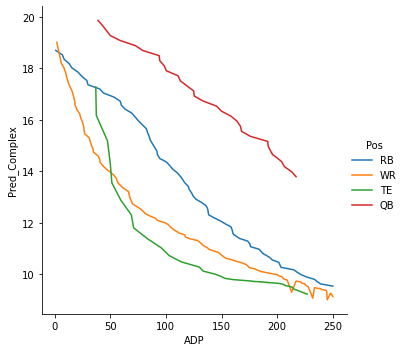

In [402]:
sns.relplot(data=curr_yr, x="ADP", y="Pred_Complex", hue="Pos", kind = "line")